<a href="https://colab.research.google.com/github/stiflerGit/CAD-Mammography/blob/master/CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
from google.colab import drive
import os
drive.mount('/content/drive')

work_dir = "./drive/My Drive/CNN/"
if not os.path.exists(work_dir):
  os.makedirs(work_dir)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
# CONSTANTS

VERSION = '0.0.1'

DATASET_PATH  = '/content/drive/My Drive/CI_FinalProject/'
IMAGE_SIZE    = (224, 224)
NUM_CLASSES   = 2
BATCH_SIZE    = 32 
NUM_EPOCHS    = 2
MODEL_FINAL = 'PT-CNN%s.h5' % VERSION

val_split = 0.2

TRAIN_IMGS_FILE_NAME = 'train_img_%d.npy' % IMAGE_SIZE[0]
TRAIN_LABELS_FILE_NAME = 'train_lab.npy'
TEST_IMGS_FILE_NAME = 'public_test_image_%d.npy' % IMAGE_SIZE[0]
TEST_LABELS_FILE_NAME = 'public_test_label.npy'

In [3]:
# PRE-PROCESS DATASET

import numpy as np
from sklearn.model_selection import train_test_split

train_gray_imgs = np.load("/content/drive/My Drive/CI_FinalProject/train_img_224.npy")
train_lbls = np.load("drive/My Drive/CI_FinalProject/train_lab.npy")

print(train_lbls.shape) # 2864 images (it is a quite small dataset)
print(np.count_nonzero(train_lbls)) # 1546 
# 1546 images belong to class 1, this means 1318 images belong to class 0
# so our class distribution is good

# we have to equally distribute otherwise the error:
### Training and validation subsets have different number of classes after the 
### split. If your numpy arrays are sorted by the label, you might want to shuffle them.
# could be raised. This is due to the distribution of classes of the labels.
# for example after the split, the training labels set contains both class 1 and 2,
# and on the other hand validation labels set contains either class 1 or class 2.
# Even if the train data would cointain both the classes it's better to equally 
# distribute the two classes over the sets.
X_train, X_val, y_train, y_val = train_test_split(train_gray_imgs, train_lbls,
                                                  test_size=val_split, 
                                                  stratify=train_lbls)

X = np.concatenate((X_train, X_val))
y = np.concatenate((y_train, y_val))

train_samples = len(X_train)
valid_samples = len(X_val)

del(X_train, X_val)
del(y_train, y_val)

# this is done to transform the gray imgs into rgb images
# X = X.astype('float32')/65536
X = np.stack((X,)*3, axis=-1)

del(train_gray_imgs)
del(train_lbls)

test_gray_imgs = np.load("drive/My Drive/CI_FinalProject/public_test_image_224.npy")
test_rgb_imgs = np.stack((test_gray_imgs,)*3, axis=-1)
test_lbls = np.load("drive/My Drive/CI_FinalProject/public_test_label.npy")

del(test_gray_imgs)

(2864,)
1546


In [4]:
# PRE-PROCESS DATASET 

from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
    rotation_range=15, 
#     zoom_range=[1.5, 0], 
    rescale=1./65536, 
    horizontal_flip=True, vertical_flip=True, 
    validation_split=val_split)

train_iterator = train_datagen.flow(X, y, batch_size=BATCH_SIZE, subset='training')

validation_iterator = train_datagen.flow(X, y, batch_size=BATCH_SIZE, subset='validation')

test_datagen = ImageDataGenerator(
    rescale=1./65536, 
    horizontal_flip=True, vertical_flip=True)

test_iterator = test_datagen.flow(test_rgb_imgs, test_lbls, batch_size=BATCH_SIZE)

Using TensorFlow backend.


In [6]:
# MODEL DEFINITION

from keras import layers
from keras import models
from keras import regularizers

model = models.Sequential()
# LAYER 1
model.add(layers.Conv2D(32, (3, 3), activation='relu',
                        input_shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)))
model.add(layers.MaxPooling2D((2, 2)))
# LAYER 2
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
# LAYER 3
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
# # LAYER 4
# model.add(layers.Conv2D(128, (3, 3), activation='relu'))
# model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Flatten())
# model.add(layers.BatchNormalization())
# with 1024 seems a lot more stable but start overfitting
model.add(layers.Dense(512, activation='relu'))
# model.add(layers.Dropout(rate=0.2))
# model.add(layers.Dense(512, activation='relu'))

model.add(layers.Dense(NUM_CLASSES, activation='softmax', name='softmax')) # model.add(layers.Dense(1, activation='sigmoid')) # for 1,0 output

####

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 222, 222, 32)      896       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 111, 111, 32)      0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 109, 109, 64)      18496     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 54, 54, 64)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 52, 52, 128)       73856     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 26, 26, 128)       0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 86528)             0         
__________

In [7]:
from keras import optimizers
from keras.callbacks import EarlyStopping

# early_stopping = EarlyStopping(monitor='val_loss', patience=10)

model.compile(
    loss='sparse_categorical_crossentropy', # loss='binary_crossentropy', # for [0,1] output
    optimizer=optimizers.RMSprop(lr=2e-5),
#   optimizer='adam',
    metrics=['acc'])

# model.fit_generator?
history = model.fit_generator(train_iterator, 
                              steps_per_epoch=train_samples // BATCH_SIZE, 
                              epochs=NUM_EPOCHS,
#                               callbacks=[early_stopping],
                              validation_data=validation_iterator,
                              validation_steps=valid_samples // BATCH_SIZE)

Instructions for updating:
Use tf.cast instead.
Epoch 1/2
71/71 [==============================] - 35s 487ms/step - loss: 0.6995 - acc: 0.5370 - val_loss: 0.7121 - val_acc: 0.4688
Epoch 2/2
71/71 [==============================] - 31s 436ms/step - loss: 0.6672 - acc: 0.5884 - val_loss: 0.6354 - val_acc: 0.7556


In [0]:
# from keras.models import Sequential, Model
# from keras import layers

# height = 224
# width = 224

# channels = 3

# num_classes = 2

# model = Sequential()
# model.add(layers.SeparableConv2D(32, 3, activation='relu', input_shape=(height, width, channels,)))
# model.add(layers.SeparableConv2D(64, 3, activation='relu'))
# model.add(layers.MaxPooling2D(2))

# model.add(layers.SeparableConv2D(64, 3, activation='relu'))
# model.add(layers.SeparableConv2D(128, 3, activation='relu'))
# model.add(layers.MaxPooling2D(2))

# model.add(layers.SeparableConv2D(64, 3, activation='relu'))
# model.add(layers.SeparableConv2D(128, 3, activation='relu'))
# model.add(layers.GlobalAveragePooling2D())

# # Dende
# # model.add(layers.Flatten())
# model.add(layers.BatchNormalization())
# model.add(layers.Dense(512, activation='relu'))
# model.add(layers.Dropout(0.5))
# model.add(layers.Dense(512, activation='relu'))
# model.add(layers.Dropout(0.5))
# model.add(layers.Dense(1, activation='sigmoid'))

In [0]:
# model.save_(os.path.join(work_dir, "ScratchCNN04.h5"))

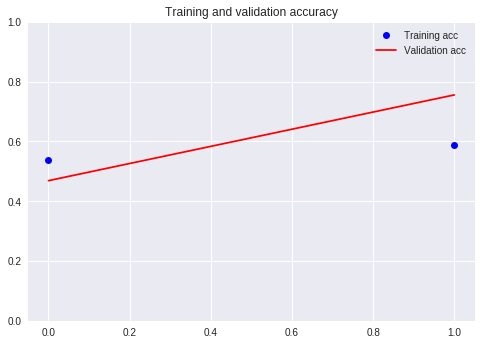

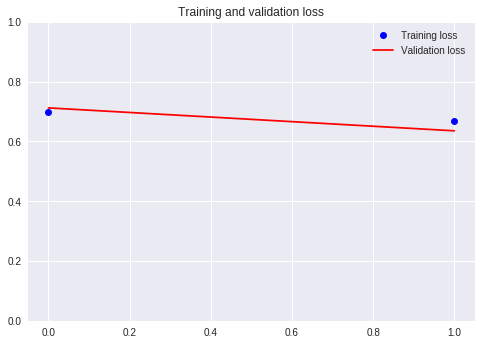

In [11]:
# plot the history
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.ylim((0,1))
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.ylim((0,1))
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

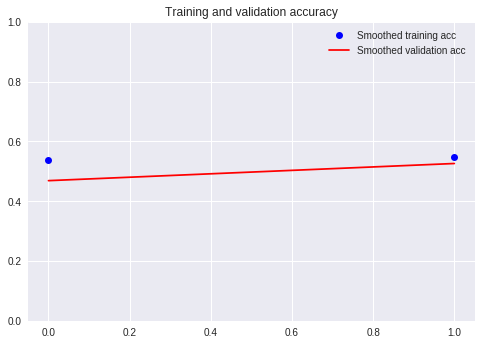

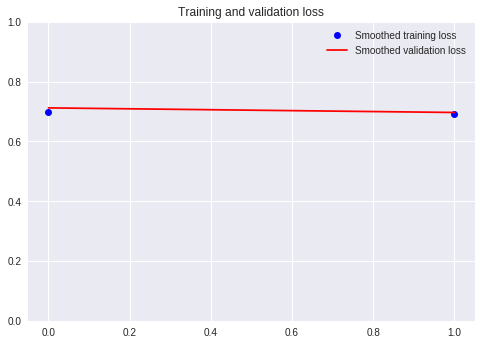

In [14]:
import matplotlib.pyplot as plt


def smooth_curve(points, factor=0.8):
  smoothed_points = []
  for point in points:
    if smoothed_points:
      previous = smoothed_points[-1]
      smoothed_points.append(previous * factor + point * (1 - factor))
    else:
      smoothed_points.append(point)
  return smoothed_points

plt.ylim((0,1))
plt.plot(epochs,
         smooth_curve(acc), 'bo', label='Smoothed training acc')
plt.plot(epochs,
         smooth_curve(val_acc), 'r', label='Smoothed validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()
plt.ylim((0,1))
         
plt.plot(epochs,
         smooth_curve(loss), 'bo', label='Smoothed training loss')
plt.plot(epochs,
         smooth_curve(val_loss), 'r', label='Smoothed validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [0]:
results = model.evaluate_generator(test_iterator, steps=22, verbose=1)

print("test_loss: ", results[0], " test_acc: ", results[1])

In [0]:
# really slow.... is train set too big?? or steps per epoch too low